# What is the likelihood of a gap?

Our goal is to develop a statistical model the tells us, for a given vessel, the chance that the satellites will fail to receive a message beacuse the density of vessels in the surrounding area is too high. We will then look for the very unlikely events, and classify these as events that were likely due to the AIS being shut off.

### **A few challenges:**
- The odds will change depending on the number of satellites in the sky, and how well the satellites are operating. Thus we'll have to modify the model depending on the day.
- Satelites don't cover the globe uniformly. They will spend more time at different latitudes, meaning that there is likely going to be a function of latitude in this equation.
- Some vessels appear to have weak AIS signals. It would be useful to identify the poorly operating devices.
- AIS devices broadcast more frequently if a vessel is moving more quickly or changing its course. This has to be accounted for somehow.

### **Initial Assumptions about AIS Interference**
If we assume that at a given time T, the satellite can hear S signals, each vessel broadcasts one signal, and there are N other vessels in the area. Then the chance that your vessels' signal will interfere with another signal, and thus be potentially lost, in this time T, is (1/C)^N. That is, if there are 500 channels, and there is only one other vessel around, the odds are about 1/500 that you'll both accidentally broadcast at the same time (AIS is, I think, smart about not broadcasting at the same time when the vessels are in line of sight with each other -- about 100km radius -- but the satellites see an area of hte earth ~1500km radius, so we can approximate that the vessels can't see each other.) 

So, the odds that you'll be heard in a given time T are proportional to (1-1/C)^N.

If the satellite stayed direclty overhead, you'd see that positions/day = K (1-1/C)^N, where K is some constant, N is the number of vessels in the footprint of the satellite. *But*, the satellites move. And you can't just average the number of vess -- you have to average this function.

Sometimes the vessel you care about will be at the corner of the satellite's radius, and sometimes the satellite will be directly above the vessel. The total number of vessels seen by the satellite (N) could be very different in those two cases, and you can't just average them. So, we need to calculate the number of vessels the satellite sees at every position of its orbit, and frequently the satellite is in each position, and which positions the satellite can see a given vessel. For simplicity, let's say the satellite visits every lat and lon equally (later we can correct for latitude). 

So, for each lat and lon, we calculate N, the number of vessels within the satellite radius.
Then, for each lat and lon, we calculate (1-1/C)^n, and average this across the satellite radius (to get every position of the satellite that will see the vessels.

For vessels in a given location, then, we expect their number of positions in a day to be a binomial distribution. 


### **The Frequency of AIS Brodcast**

The movement of the vessel affects how frequently it will try to broadcast its location. Based on http://www.milltechmarine.com/faq.htm:

Class A:
 Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver  
 Ship at anchor or moored        | 3 min                 | 6 min                    
 SOG 0-14 knots                  | 10 sec                | 20 sec                   
 SOG 0-14 knots, changing course | 3.3 sec               | 6.6 sec                  
 SOG 14-23 knots                 | 6 sec                 | 12 sec                   
 SOG 14-23 knots, changing course| 2 sec                 | 4 sec                    
 SOG >23 knots                   | 2 sec                 | 4 sec                    
 Ship Static Information         | 6 min                 | 12 min                  

Class B:    
Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver
SOG < 2 knots                   | 3 min                 | 6 min                   
SOG > 2 knots                   | 10 sec                | 20 sec                   
Ship Static Information         | 6 min                 | 12 min     

Message Types
Class A: 1,2,3
Class B: 18,19


**For a first cut, we will analyze the positions of a vessel that never goes slower than 2 knots if it is Class B, or is never 0 knots if it is Class A, as these messages are supposed to be ~20 to ~60 times less frequent.** 


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import math
import cPickle 


In [ ]:
import bq  
client = bq.Client.Get()


In [182]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [151]:
def make_map(raster,title=None, colorbar_label=None, maximum=100, 
             minimum=1, scale_type ="log",cutoff=0,savefig=0, 
             png="temp.png", continent_color = '#111111' ):
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,7]
    firstlat = 90-cutoff
    lastlat = -90+cutoff
    firstlon = -180
    lastlon = 180
    scale = cellsize
    truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)
    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
    fig = plt.figure()
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
    m.drawmapboundary(fill_color='#111111')
    # m.drawcoastlines(linewidth=.2)
    m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
    x = np.linspace(-180, 180, 360/cellsize)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar
    if scale_type == 'log':
        norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    else:
        norm = colors.Normalize(vmin=minimum, vmax=maximum)

    m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
    if title == None:
        title = "A Raster of Some Sorts"
    plt.title(title, color = "#000000", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
    if scale_type == "log":
        lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
        cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
        the_labels = []
        for l in lvls:
            if l>=1:
                l = int(l)
            the_labels.append(l)
        cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#000000")
    else:
        cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))
        
    cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#000000")
    ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='#000000', fontsize=6)
    if savefig:
        plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
    plt.show()

In [223]:
q = '''
SELECT
  integer(FLOOR(first_lat*10)) lat_bin,
  integer(FLOOR(first_lon*10)) lon_bin,
  integer(FLOOR(avg_lat*10)) lat_bin_avg,
  integer(FLOOR(avg_lon*10)) lon_bin_avg,
  satellite_positions sat_positions,
  terrestrial_positions terrestrial_positions,
  positions_weighted,
  avg_speed,
  slow_pings
FROM
(SELECT
  mmsi,
  SUM( CASE WHEN speed = 0 OR (speed<=2 AND type IN (18, 19)) THEN 180 
     WHEN (speed > 0 AND speed <14 AND type IN (1,2,3)AND turn = 0 )
         OR (speed>2 AND type IN (18,19)) THEN 10 
      when speed>0 and speed<14 and type in (1,2,3) and turn !=0 then 3.3
      when speed>=14 and speed<23 and type in (1,2,3) and turn = 0 then 6
      when type in (1,2,3) and (speed>=23 or (speed>=14 and turn !=0)) then 2
      END) positions_weighted,
   first(lat) first_lat,
   first(lon) first_lon,
   avg(lat) avg_lat,
   avg(lon) avg_lon,
   max(lat) max_lat,
   min(lat) min_lat,
   max(lon) max_lon,
   min(lon) min_lon,
   avg(speed) avg_speed,
   sum(if( (speed=0 and type in (1,2,3)) or (speed<2 and type in (18,19)),1,0 )) slow_pings,
   sum( if(REGEXP_REPLACE(tagblock_station, 'u', '') IN ('rORBCOMM000',
        'rORBCOMM01',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),1,0)) terrestrial_positions,
   sum( if(REGEXP_REPLACE(tagblock_station, 'u', '') not IN ('rORBCOMM000',
        'rORBCOMM01',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),1,0)) satellite_positions,       
FROM
  [pipeline_normalize.20150101]
WHERE
  type IN (1,2,3,18,19) and lat is not null and lon is not null and speed is not null and turn is not null
group by mmsi
)
  where
  max_lat - min_lat <5
  AND (max_lon - min_lon < 10
    OR first_lon > 170
    OR first_lon < -170)
  AND mmsi IN (select mmsi from
[scratch_david_gapanalysis.good_mmsi_2015_1000pings])
'''

positions = Query(q)

Waiting on bqjob_r7cb929094e60fce9_0000015343908a16_17 ... (11s) Current status: DONE   
Query time: 54.2345890999 seconds.


In [224]:
cPickle.dump(positions, open('../../data/density/20150101_v2_vessels.p', 'wb')) 

In [3]:
positions = cPickle.load(open('../../data/density/20150101_v2_vessels.p', 'rb'))

In [4]:
len(positions)

115560

In [162]:
# first calculate a raster of vessel locations from the query
cellsize = 2
num_lons = 360/cellsize
num_lats = 180/cellsize

vessels = np.zeros(shape=(num_lats,num_lons)) 
for row in positions:
    lat = int(row[0])
    lon = int(row[1])
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        vessels[lat_index][lon_index] += 1 # one vessel 

In [7]:
vessels.max()

6774.0

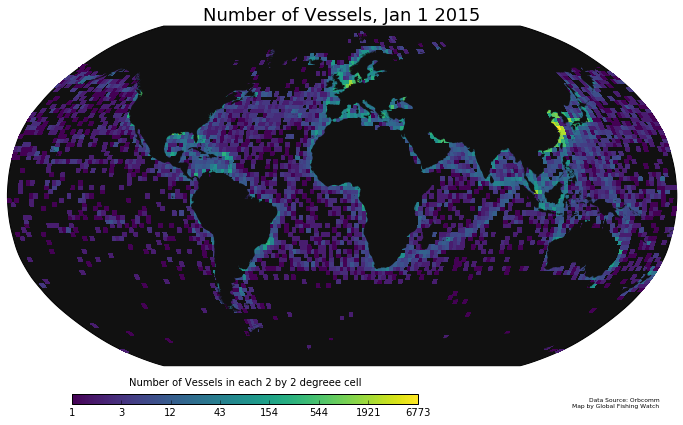

In [152]:
make_map(vessels,title="Number of Vessels, Jan 1 2015",
             colorbar_label="Number of Vessels in each 2 by 2 degreee cell", maximum=vessels.max(), minimum=1)

In [105]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_between_boxes(lat_box_0,lon_box_0,lat_box_1,lon_box_1):
    """
    Convert our lat and lon index to the lat and lon of the middle of
    a cell
    """
    lat1 = lat_box_0*cellsize-90+cellsize/2.
    lat2 = lat_box_1*cellsize-90+cellsize/2.
    lon1 = lon_box_0*cellsize-180+cellsize/2.
    lon2 = lon_box_1*cellsize-180+cellsize/2.
    return haversine(lon1, lat1, lon2, lat2)


In [122]:
# Now we have the problem of averaging on a sphere. There are geospatial
# functions to do this, but I'll just write my own here
# grid_for_average[lat_box][lon_box] is a list of indices representing
# the satellite's footprint when it is at an index lat_box, lon_box
# on the grid.

satellite_radius = 2800 # measured in km, ~1500 km
grid_for_average = [ [[] for i in range(num_lons)] for k in range(num_lats)]
for lat_box in range(num_lats):
    for lon_box in range(num_lons):
        # lat_above and lat_below are so that we don't have to 
        # loop through the entire grid
        lat_above = int(lat_box + satellite_radius/110. + 1)
        if lat_above > num_lats: lat_above = num_lats
        lat_below = int(lat_box - satellite_radius/110. - 1)
        if lat_below < 0: lat_below = 0
        for i in range(lat_below,lat_above):
            for k in range (num_lons):
                dist = distance_between_boxes(i,k,lat_box,lon_box)
                if dist < satellite_radius:
                    grid_for_average[lat_box][lon_box].append([i,k])

In [140]:
# Now we add count the number of vessels that are in the satellite's footprint
# when the satellite is at a given lat and lon
sat_footprints = np.zeros(shape=(num_lats,num_lons)) 
for i in range(num_lats):
    for j in range(num_lons):
        for item in grid_for_average[i][j]:
            sat_footprints[i][j] += vessels[item[0]][item[1]]

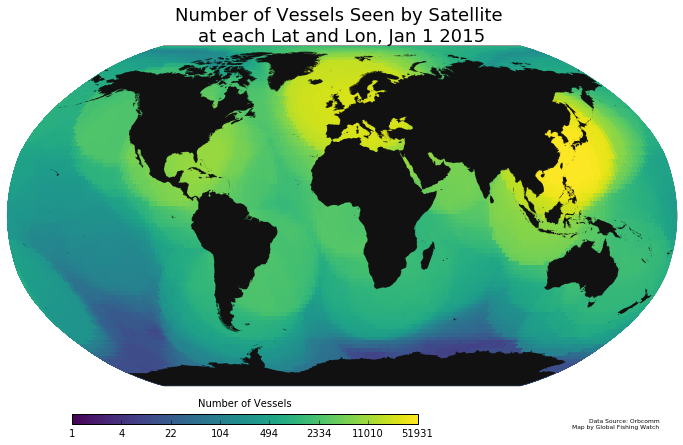

In [153]:
make_map(sat_footprints,title="Number of Vessels Seen by Satellite \nat each Lat and Lon, Jan 1 2015",
             colorbar_label="Number of Vessels", maximum=sat_footprints.max(), minimum=1)

In [154]:
#estimate the pings effect for each point
sat_pings_footprint = np.zeros(shape=(num_lats,num_lons))
for i in range(num_lats):
    for j in range(num_lons):
        # note that I don't know if this number should be 2500 -- I just guessed
        # with a few different numbers to see what worked best.
        sat_pings_footprint[i][j] = (1-1/2500.)**sat_footprints[i][j]

In [217]:
# Now, average again, because the satellite is moving. 
# This assumes that 
estimated_positions = np.zeros(shape=(num_lats,num_lons))
density_averaged = np.zeros(shape=(num_lats,num_lons))
for i in range(num_lats):
    for j in range(num_lons):
        a = 0
        for item in grid_for_average[i][j]:
            # crap, have to adjust by area 
            latitude = (i-45)*2+1 # i goes from 0 to 90, map to -91 to 89, every two degrees
            area = math.cos(latitude*3.1416/180.)
            estimated_positions[i][j] += sat_pings_footprint[item[0]][item[1]]*area
            density_averaged[i][j] +=  sat_footprints[item[0]][item[1]]/area
            a += area
        estimated_positions[i][j] = (157/a)*estimated_positions[i][j]
        # so, the a is just to make sure that the footprint area is the same at 
        # all latitudes, and the 157 is just a constant to get the predicted
        # number of positions roughly correct



In [218]:
# what are the actual positions per day?
actual_positions = np.zeros(shape=(num_lats,num_lons))
number_of_vessels = np.zeros(shape=(num_lats,num_lons))

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:
    # and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        actual_positions[lat_index][lon_index] += sat_pos
        number_of_vessels[lat_index][lon_index] += 1
        
for i in range(num_lats):
    for j in range(num_lons):
        if number_of_vessels[i][j]:
            actual_positions[i][j] = float(actual_positions[i][j])/number_of_vessels[i][j]

actual_positions[actual_positions==0] = np.nan


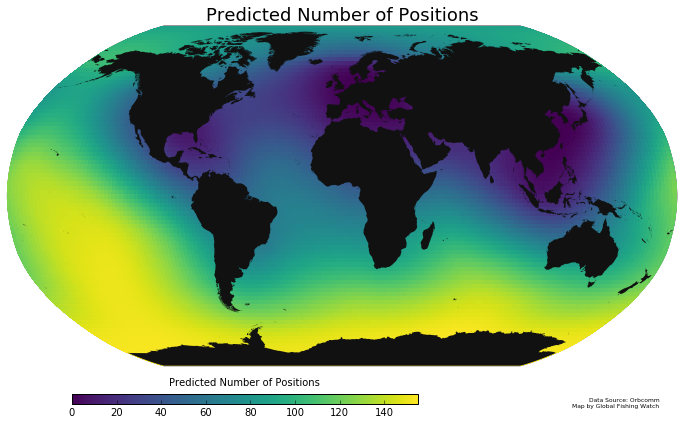

In [219]:
make_map(estimated_positions,title="Predicted Number of Positions",scale_type="linear",
             colorbar_label="Predicted Number of Positions", maximum=estimated_positions.max(), minimum=0)

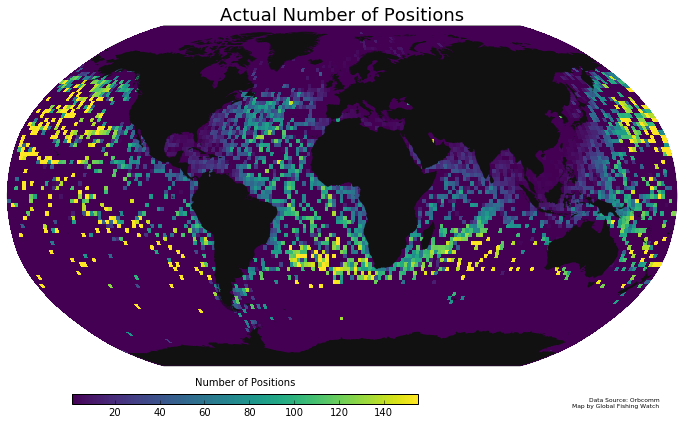

In [220]:
make_map(actual_positions,title="Actual Number of Positions",scale_type="linear",
             colorbar_label="Number of Positions", maximum=estimated_positions.max(), minimum=1)

0.718997633955 0.00919460920695 1.21514569479 1.01390088305


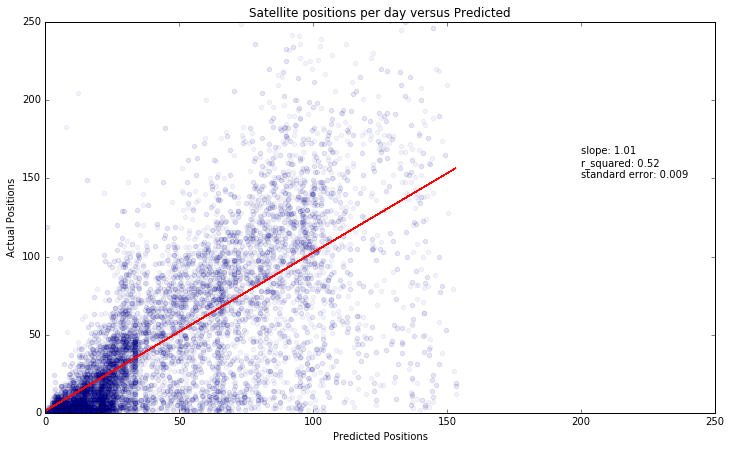

In [254]:
# Plot the relationship for all vessels

den = []
pos = []
predicted_pos = []
pos_weighted = []

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and ((lat>=0 and lat<900) or (lat<0 and lat>-900)) and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:# and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(sat_footprints[lat_index][lon_index])
        predicted_pos.append(estimated_positions[lat_index][lon_index])
        pos_weighted.append(float(row[6]))
        pos.append(sat_pos)


fig = plt.figure()
plt.rcParams["figure.figsize"] = [12,7]

ax = fig.add_subplot(1,1,1)
plt.scatter(predicted_pos, pos,  alpha=.05)
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_pos,pos)
print r_value, std_err, intercept, slope
y = [slope*x + intercept for x in predicted_pos]

plt.plot(predicted_pos,y, "r")
plt.title("Satellite positions per day versus Predicted")
plt.xlabel('Predicted Positions')
plt.ylabel('Actual Positions')
plt.xlim([0,250])
plt.ylim([0,250])
thetext = "slope: "+ str(round(slope,2))+"\nr_squared: "+str(round(r_value**2,2))+"\nstandard error: "+str(round(std_err,3))
ax.text(200, 150, thetext, fontsize=10)
plt.show()




0.746981174725 0.0300899448168 -0.189726021706 0.974565493075


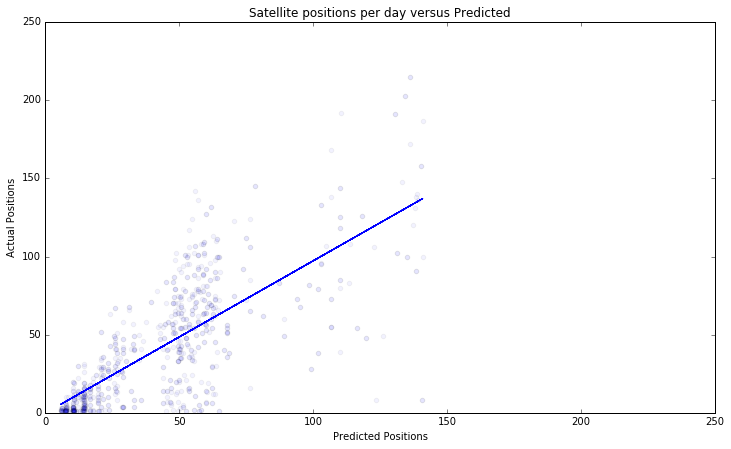

In [261]:
# How does the relationship vary by latitude? I expect that it does.

predicted_pos = [[] for i in range(3)]
pos = [[] for i in range(3)]

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:# and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        if (lat>=0 and lat<30) or (lat<=0 and lat>-30):
            i = 0
        elif (lat>=30 and lat<60) or (lat<-30 and lat>-60):
            i = 1
        else:
            i = 2
        predicted_pos[i].append(estimated_positions[lat_index][lon_index])
        pos[i].append(sat_pos)


plt.rcParams["figure.figsize"] = [12,7]


for x, y in zip(predicted_pos, pos):
    plt.scatter(x,y, alpha=.05)
    plt.title("Satellite positions per day versus Predicted")
    plt.xlabel('Predicted Positions')
    plt.ylabel('Actual Positions')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print r_value, std_err, intercept, slope
    y1 = [slope*i + intercept for i in x]
    plt.plot(x, y1)
    


#     thetext = "slope: "+ str(round(slope,2))+"\nr_squared: "+str(round(r_value**2,2))+"\nstandard error: "+str(round(std_err,3))
plt.xlim([0,250])
plt.ylim([0,250])
plt.show()



0.755493634435 0.0231638545734 3.98441453767 0.962723338287


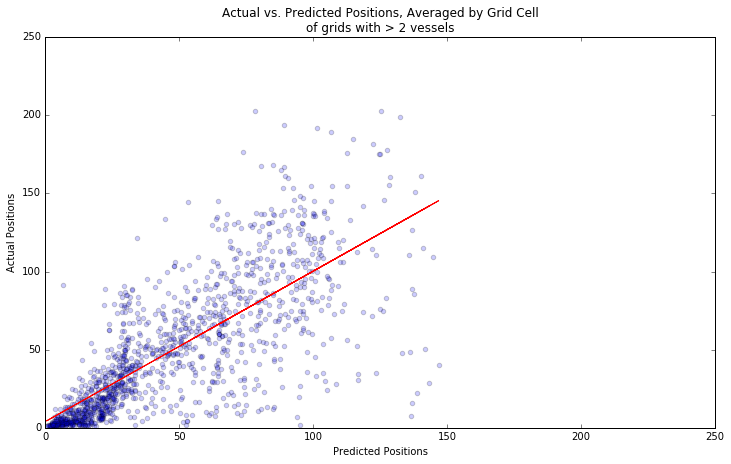

In [221]:
# plot the average number of positions for a given cell
# against the peredicted number of positions for that cell

predicted_pos = []
pos = []
for i in range(num_lats):
    for j in range(num_lons):
        if actual_positions[i][j] and number_of_vessels[i][j]>=3: # has to be at least three
            predicted_pos.append(estimated_positions[i][j])
            pos.append(actual_positions[i][j])
plt.scatter(predicted_pos, pos,alpha = .2)

slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_pos,pos)
print r_value, std_err, intercept, slope
y = [slope*x + intercept for x in predicted_pos]
plt.title("Actual vs. Predicted Positions, Averaged by Grid Cell\nof grids with > 2 vessels")
plt.xlabel('Predicted Positions')
plt.ylabel('Actual Positions')
plt.xlim([0,250])
plt.ylim([0,250])
plt.plot(predicted_pos,y, "r")
plt.show()


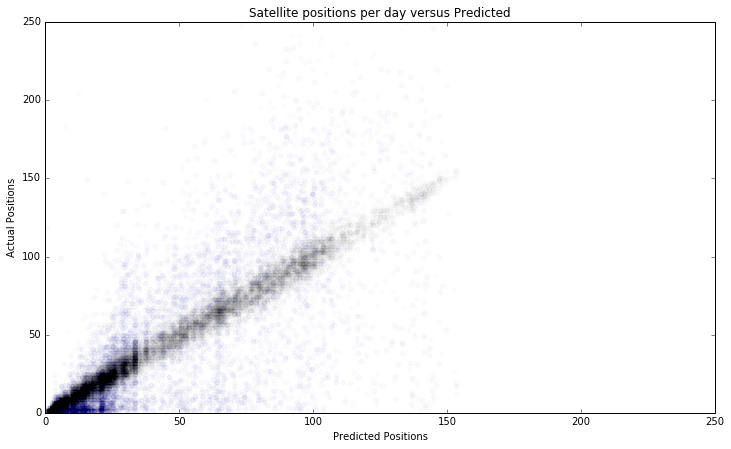

In [244]:
# What does this data look like if I create it myself?

n = 157 # this appears to be the max of the predicted values

made_up_positions = []
predicted_pos = []
pos = []

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and ((lat>=0 and lat<900) or (lat<0 and lat>-900)) and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:# and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        predicted_pos.append(estimated_positions[lat_index][lon_index])
        p = estimated_positions[lat_index][lon_index]/157
        made_up_positions.append(np.random.binomial(n, p))
        pos.append(sat_pos)

plt.scatter(predicted_pos, pos, alpha=.01)
plt.scatter(predicted_pos, made_up_positions, color='black',  alpha=.01)
plt.title("Satellite positions per day versus Predicted")
plt.xlabel('Predicted Positions')
plt.ylabel('Actual Positions')
plt.xlim([0,250])
plt.ylim([0,250])
plt.show()


0.699075651254 0.0812471416167 -0.699325192749


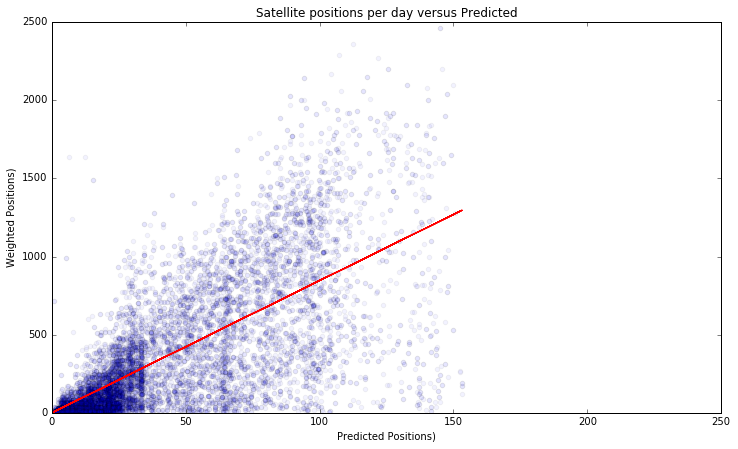

In [228]:
plt.scatter(predicted_pos, pos_weighted,  alpha=.05)
plt.title("Satellite positions per day versus Predicted")
plt.xlabel('Predicted Positions)')
plt.ylabel('Weighted Positions)')
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_pos, pos_weighted)
print r_value, std_err, intercept

y = [slope*x + intercept for x in predicted_pos]

plt.plot(predicted_pos,y, "r")
plt.xlim([0,250])
plt.ylim([0,2500])
plt.show()

In [ ]:
# create the density that is seen by satellites

def create_average_raster(filename):
    # load the file that helps with the satellite averaging
    grid_for_average = np.load(filename)
    avgs = np.zeros(shape=(num_lats,num_lons)) # 2 by 2 grid

    for i in range(num_lats):
        for j in range(num_lons):
            count = len(grid_for_average[i][j])
            total = 0
            for item in grid_for_average[i][j]:
                if vessels[item[0]][item[1]]:
                    total+= vessels[item[0]][item[1]]*(item[2]**2)
                    #total += np.log10(float(vessels[item[0]][item[1]]))#*item[2]
            avgs[i][j] = total/4.
            # divide by 4 because the satellite sees only 1/4 of the area that we're 
            #averaging over
            #avgs[i][j]=10**(float(total)/len(grid_for_average[i][j])) 

    return avgs


In [12]:
infile = '../../data/density/grid_for_average_2degree.npy'
averages = create_average_raster(infile)

In [ ]:
# make a chart of pings versus the average density seen by the satellite


den = []
pos = []
lats = []
pos_weighted = []
count = 0

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:# and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        if (density_averaged[lat_index][lon_index])<1000:
            den.append(density_averaged[lat_index][lon_index])
            pos.append(sat_pos)
            lats.append(lat)


plt.rcParams["figure.figsize"] = [12,7]

x = []
y = []
for d, p, l in zip(den, pos, lats):
    if p and d:# and d<10**.1:#abs(l)>0 and p and d:# and d>10**1:
        x.append(d)
        y.append(p)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#     plt.scatter(np.log10(x), np.log10(y), alpha=.02
plt.scatter(x, np.log10(y), alpha=.02
           )#, color = color)

logA = x
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

thetext = "slope: "+ str(round(slope,2))+"\nr_squared: "+str(round(r_value**2,2))+"\nstandard error: "+str(round(std_err,3))
plt.scatter(x, ys, color = 'red')

ax.text(2, 3.5, thetext, fontsize=10)

# plt.xlim([0,4.5])
plt.ylim([-.5,4])

# print slope
# print coefficients
# print r_value
# print p_value
#print slope,std_err,p_value, r_value**2

plt.title("Satellite positions per day versus density")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()


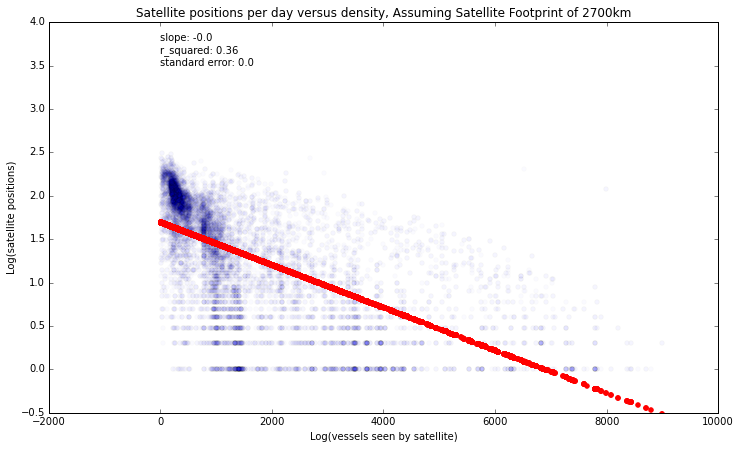

In [28]:
make_averages(averages,2700)

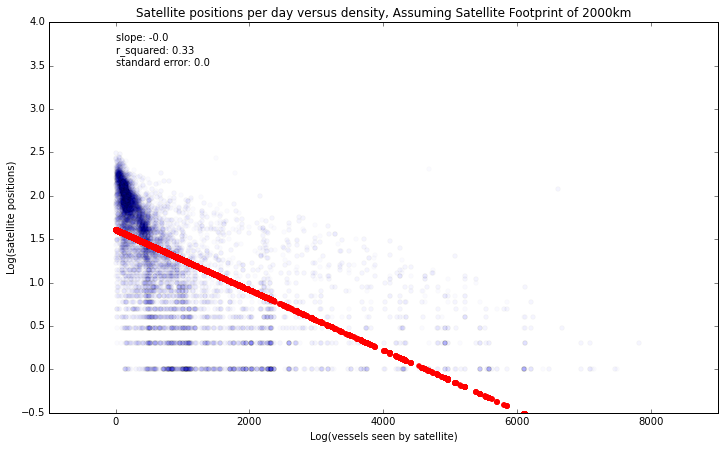

In [29]:
make_averages(averages_2000,2000)

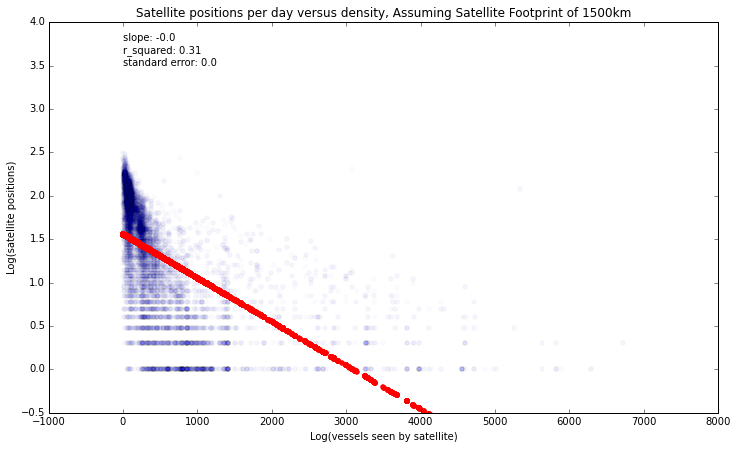

In [30]:
make_averages(averages_1500,1500)

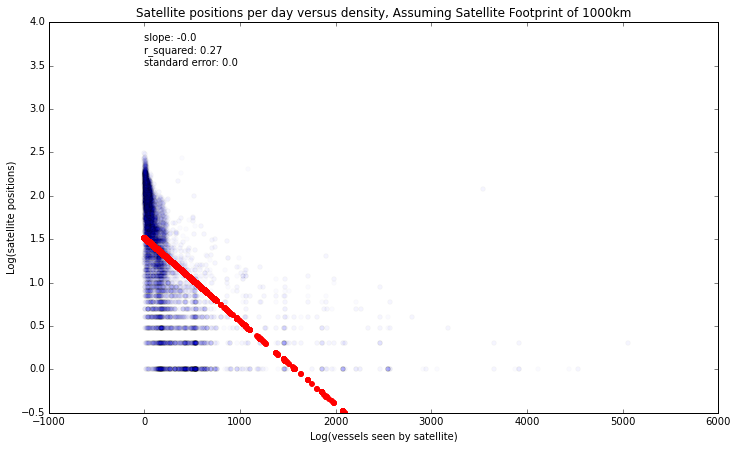

In [31]:
make_averages(averages_1000,1000)

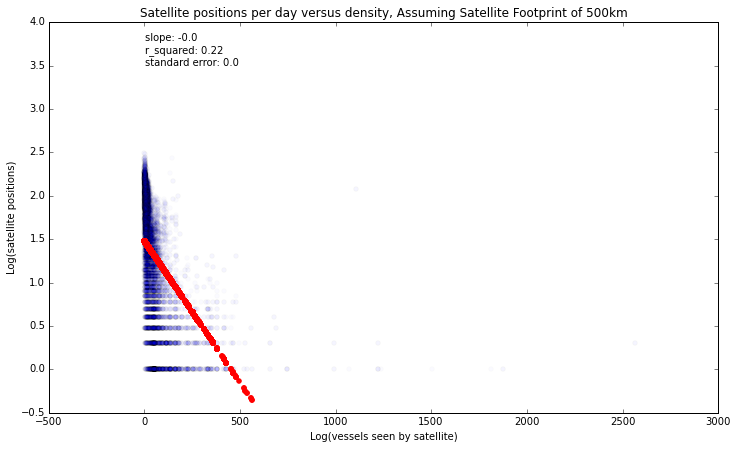

In [32]:
make_averages(averages_500,500)

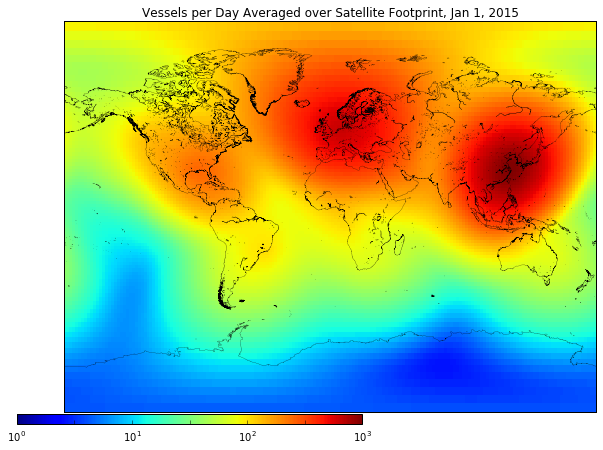

In [539]:
# map the vessel density seen by satellite

firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
plt.clf()

m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
m.drawcoastlines(linewidth=.2)
#m.fillcontinents('#555555')# , lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360/cellsize )
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)

from matplotlib import colors,colorbar

norm = colors.LogNorm(vmin=1, vmax=1000)

m3 = int(averages.max()**.3333)

m.pcolormesh(converted_x, converted_y, averages, norm=norm, vmin=1, vmax=m3**3)

t = "Vessels per Day Averaged over Satellite Footprint, Jan 1, 2015"
plt.title(t)

ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) 
norm = colors.Normalize(vmin=0, vmax=1000)
norm = colors.LogNorm(vmin=1, vmax=1000)
lvls = np.logspace(0,3,7)

cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)

# cb.ax.set_xticklabels(["<1" ,int(m3**.5), m3, int(m3**1.5), m3*m3,int(m3**2.5), str(int(m3**3))+"+"], fontsize=10)


plt.savefig("satellite_footprint2by2_500b.png",bbox_inches='tight',dpi=450,transparent=True,pad_inches=0)

plt.rcParams["figure.figsize"] = [12,8]

plt.show()

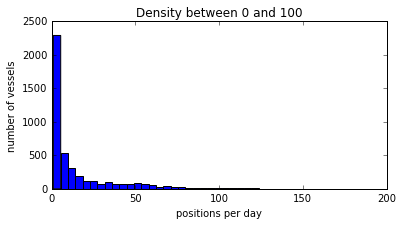

Density between 0 and 100 :  64


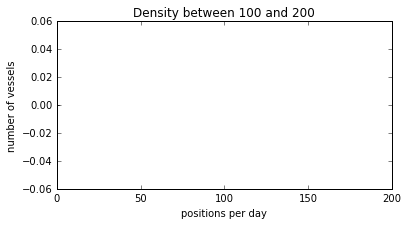

Density between 100 and 200 : 

ZeroDivisionError: integer division or modulo by zero

In [310]:
minimum = 0
maximum = 100
plt.rcParams["figure.figsize"] = [6,3]

for i in range(18):

    x = []

    plt.clf()
    if i > 0:
        minimum = maximum
    maximum += 100*i
    
    less_than_5 = 0
    count = 0
    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<500:
            x.append(p)
            if p<10:
                less_than_5 += 1
            count+=1
    plt.title("Density between "+str(minimum)+" and "+str(maximum))     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.xlim([0,200])
    plt.show()
    print "Density between "+str(minimum)+" and "+str(maximum) + " : ", int(100*less_than_5/count)

In [13]:
# okay, let's look at only fishing vessels

q = '''
SELECT
  integer(FLOOR(a_first_lat*10)) lat_bin,
  integer(FLOOR(a_first_lon*10)) lon_bin,
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  a_satellite_positions sat_positions,
  a_positions positions
FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10
    OR a_first_lon > 170
    OR a_first_lon < -170)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014]
  )
'''

positions_fishing_vessels = Query(q)


Waiting on bqjob_r6a16a99088a29707_000001530ad38aee_2 ... (7s) Current status: DONE   
Query time: 16.1007111073 seconds.


In [14]:
# now make a chart of pings versus position

den = []
pos = []
count = 0

for row in positions_fishing_vessels:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = row[4]
    all_pos = row[5]
    count += 1
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(int(sat_pos))

-0.585306674036 0.0293862270318 3.75524846468e-79


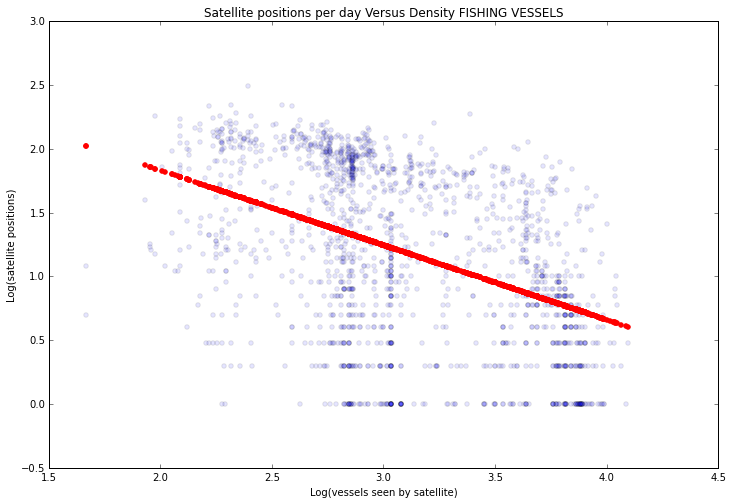

In [15]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

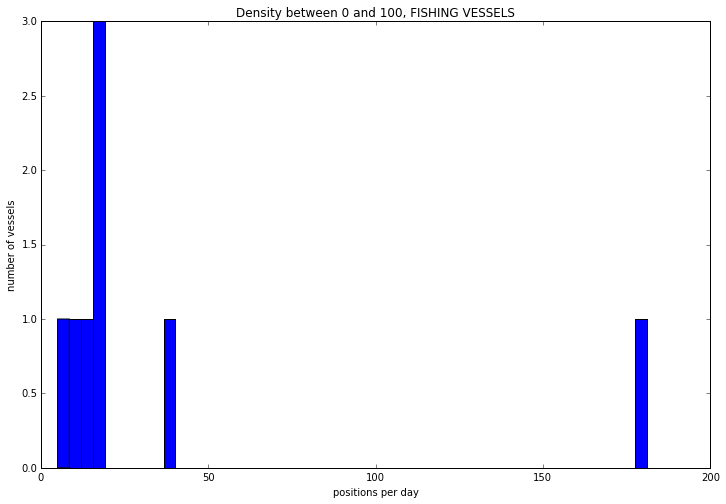

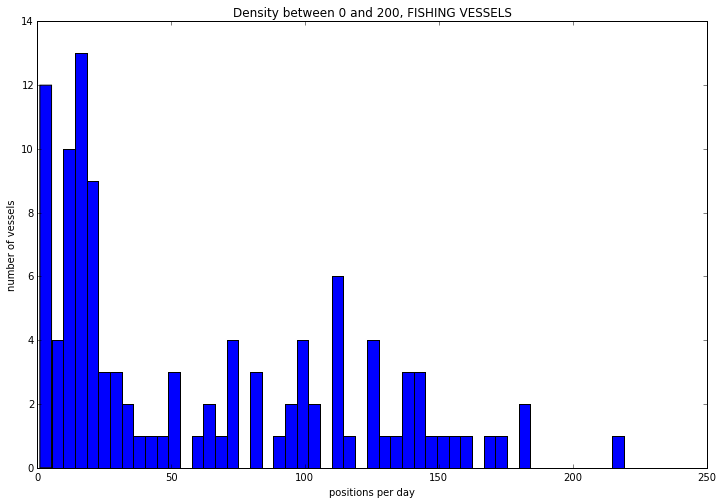

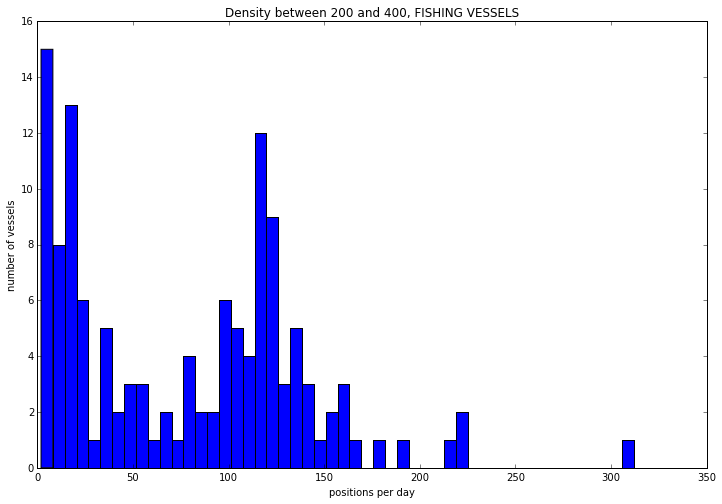

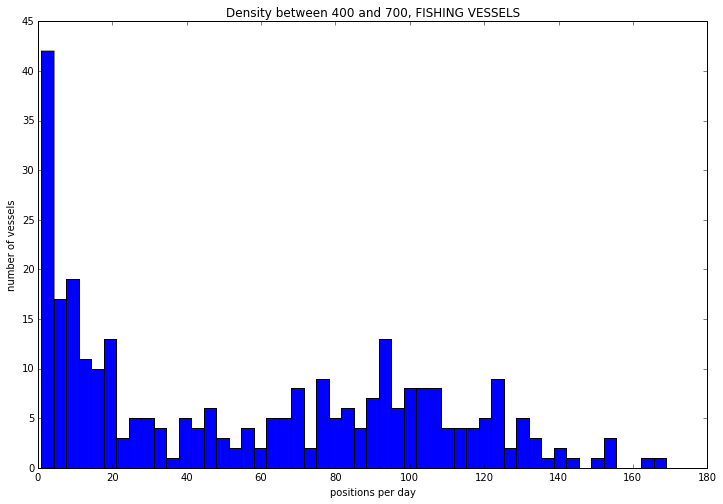

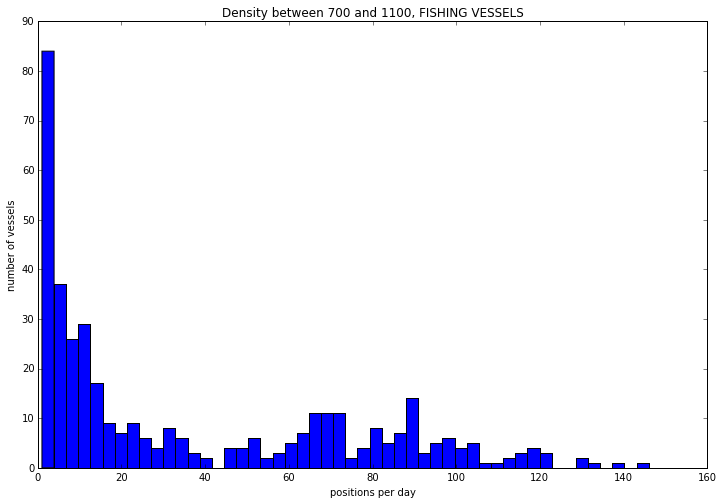

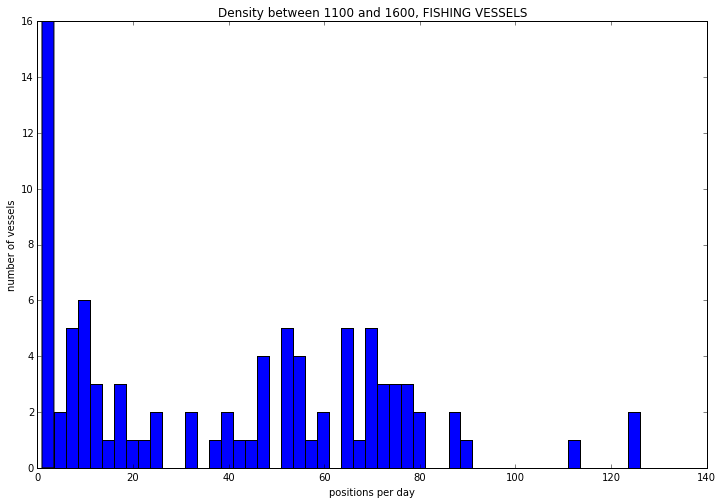

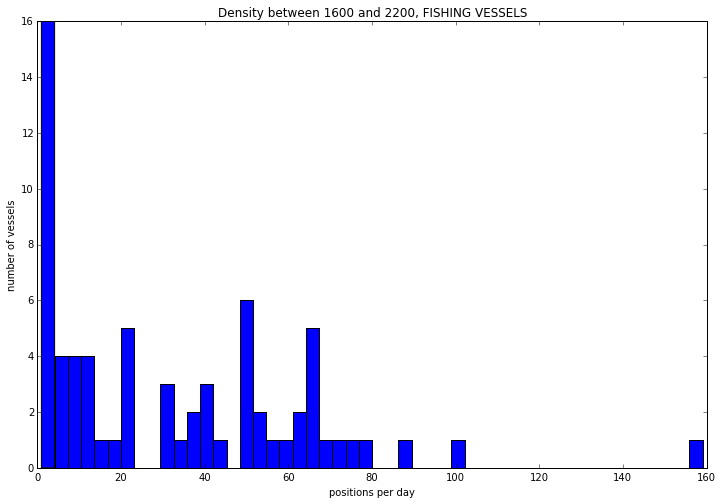

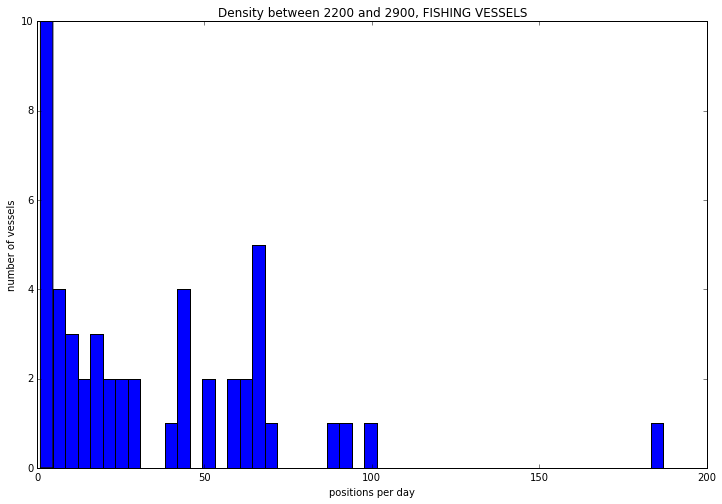

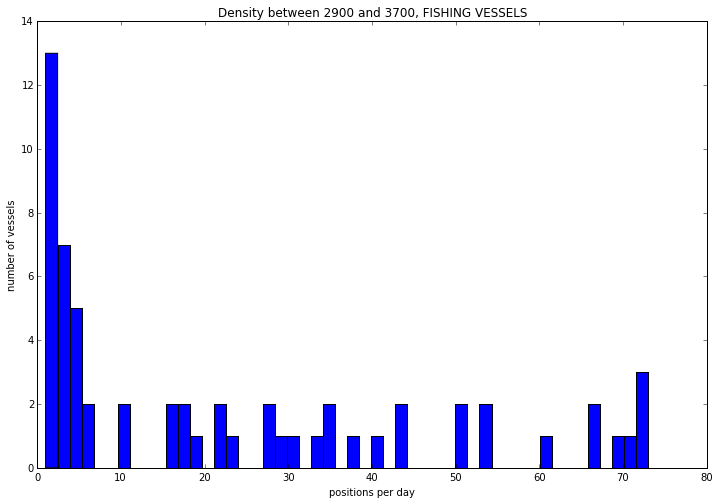

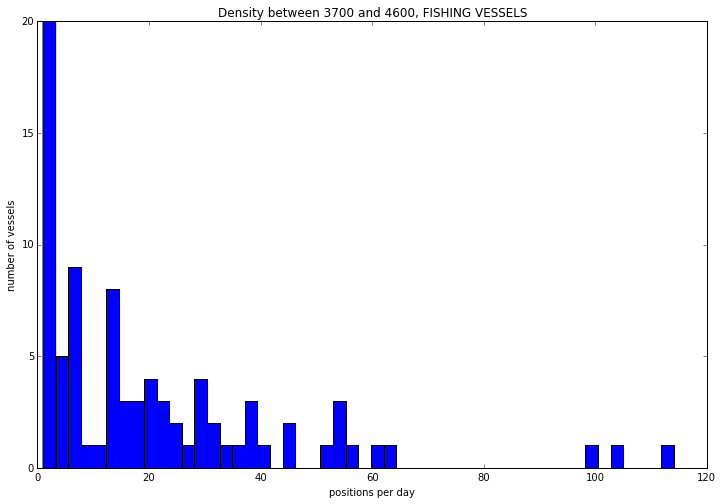

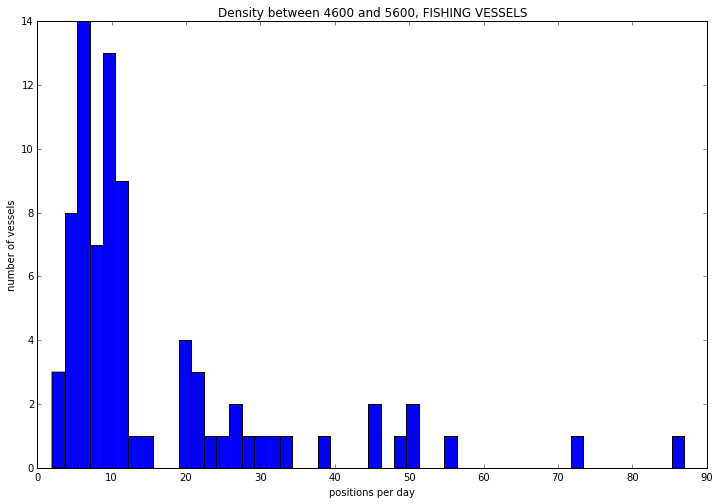

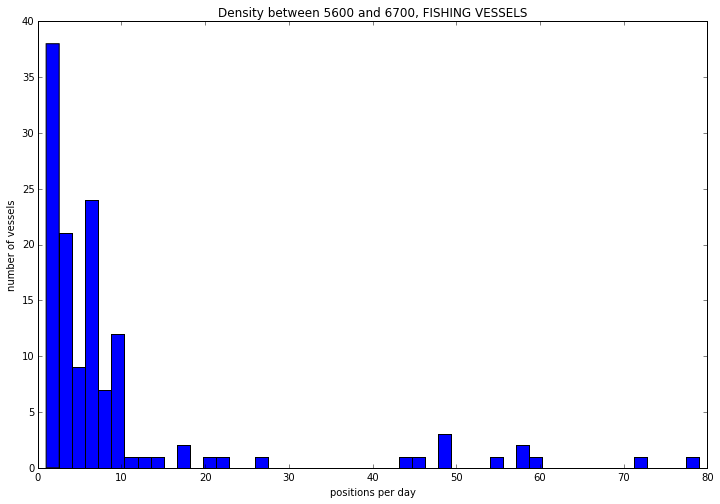

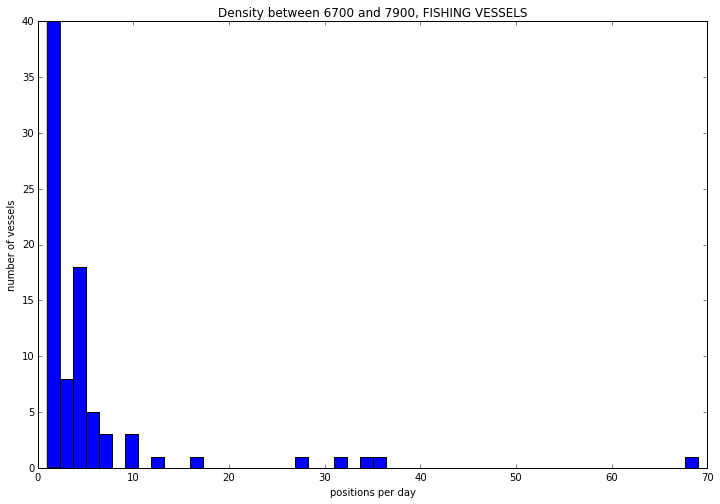

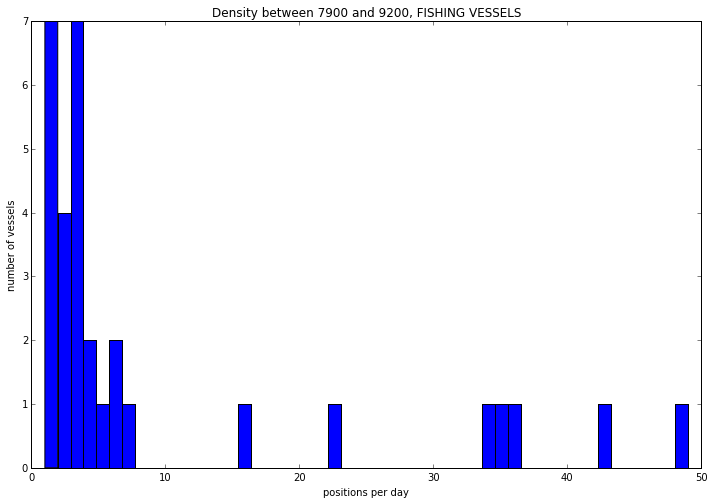

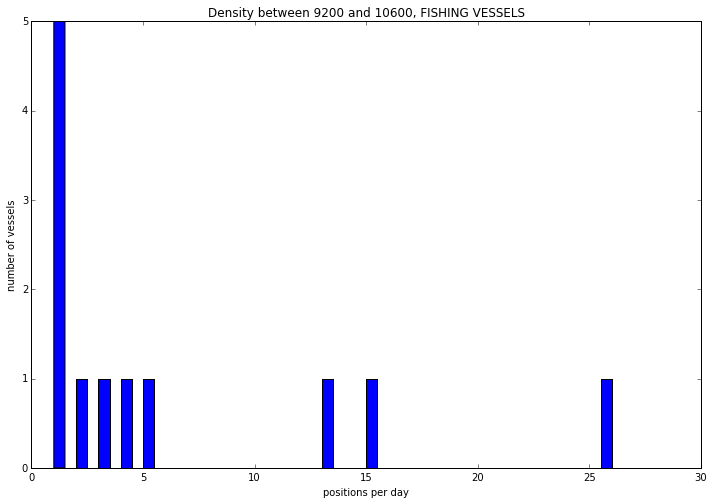

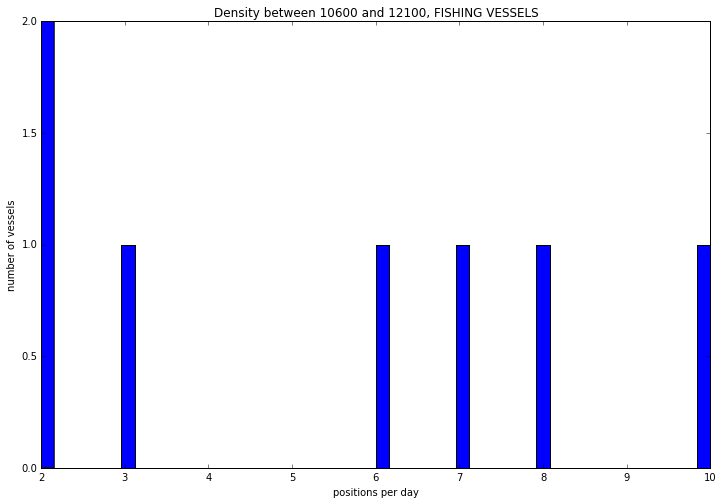

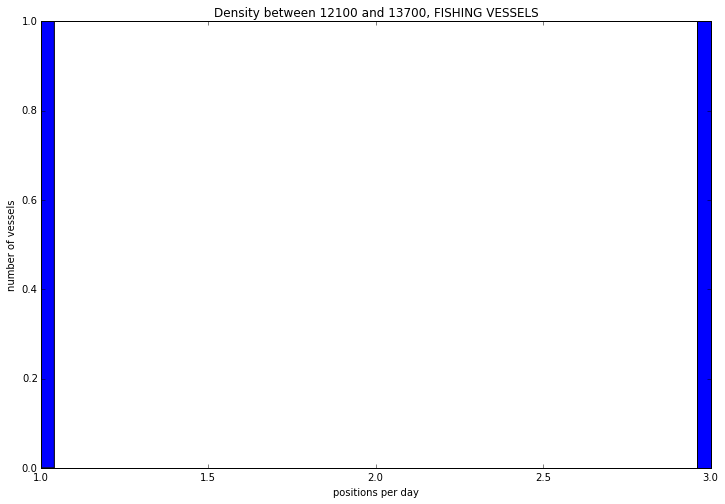

ValueError: x must have at least one data point

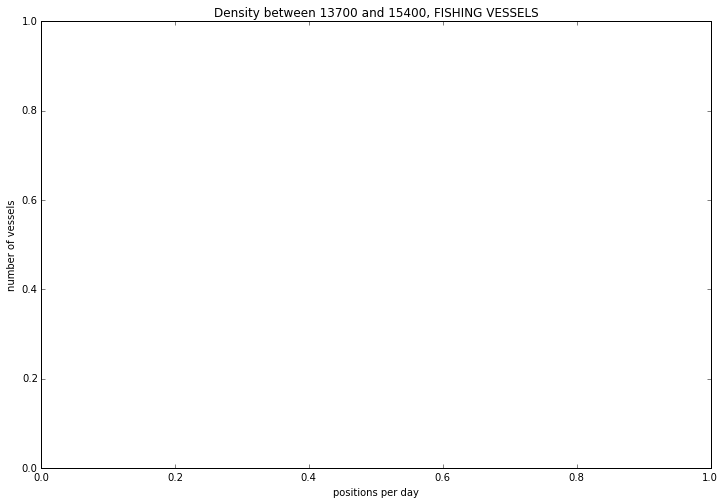

In [16]:
minimum = 0
maximum = 100

for i in range(18):

    x = []

    plt.clf()
    if i > 1:
        minimum = maximum
    maximum += 100*i

    for p, d in zip (pos, den):
        if d>minimum and d<maximum and p<400:
            x.append(p)
    plt.title("Density between "+str(minimum)+" and "+str(maximum)+", FISHING VESSELS")     
    plt.xlabel("positions per day")
    plt.ylabel("number of vessels")
    plt.hist(x, bins=50)
    plt.show()

In [ ]:
# okay, let's look at averages

q = '''
SELECT
  integer(FLOOR(a_avg_lat*10)) lat_bin_avg,
  integer(FLOOR(a_avg_lon*10)) lon_bin_avg,
  avg(a_satellite_positions) sat_positions,
  count(*)
  FROM
  [scratch_david_gapanalysis.ave_locations_2015_with_density_v2]
WHERE
  a_positions = a_satellite_positions
  and a_date = "2015-01-01"
  AND a_max_lat - a_min_lat <5
  AND (a_max_lon - a_min_lon < 10)
  AND a_mmsi IN (select mmsi from
[scratch_david_mmsi_lists.Combinedfishing_2014])
GROUP BY lat_bin_avg, lon_bin_avg
'''

positions_fishing_vessels_avgs = Query(q)


In [ ]:
# now make a chart of pings versus position

den = []
pos = []

for row in positions_fishing_vessels_avgs:
    lat = int(row[0])
    lon = int(row[1])
    sat_pos = row[2]
    number = int(row[3])
    # must only be satellite positions
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(averages[lat_index][lon_index])
        pos.append(float(sat_pos))

In [ ]:
x = den
y = pos

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.scatter(np.log10(x), np.log10(y), alpha=.1)#, color = color)
# plt.scatter(x1, y1, alpha=1)#, color = color)

logA = np.log10(x)
logB = np.log10(y)
coefficients = np.polyfit(logA, logB, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(np.log10(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)

plt.scatter(np.log10(x), ys, color = 'red')


# print slope
# print coefficients
# print r_value
# print p_value
print slope,std_err,p_value

plt.title("AVERAGE Satellite positions per day Versus Density FISHING VESSELS")
plt.xlabel('Log(vessels seen by satellite)')
plt.ylabel('Log(satellite positions)')

plt.show()

In [26]:
math.cos(-89*3.14/180.)

0.018239759727164722

In [114]:
def hello(a,b=None):
    if b:
        print "what"
    else:
        print a


hello(a="yes")

yes


In [247]:
np.random.binomial(100,.5,10)

array([47, 46, 55, 55, 47, 53, 45, 37, 47, 55])